1) Load images
2) Threshold image
3) Perform edge detection
4) Compute the Hough transform &  determine the angle of line
5) Project the image on a line with approppriate bining.
6) Do gaussian smoothing 
7) Perform differentiation and windowing.
8) Obtain the MTF by windowing & taking FFT.


In [154]:
import os
import sys
import cv2

# Python modules for figure visualization
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter1d

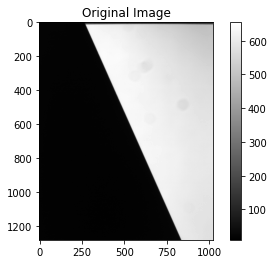

In [155]:
data_path = 'data\data\lab_3_2a1_exp35_knife.npy'
data = np.load(data_path)

# Averaging image to remove noise
img = np.mean(data, axis=0)
img = np.transpose(img)

# Visualize original image
figure = plt.imshow(img, cmap='gray')
color = plt.colorbar(figure)
plt.title('Original Image')
plt.show()


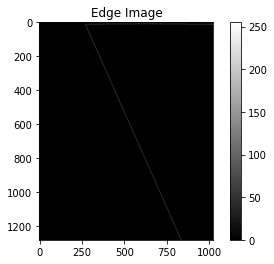

In [156]:
# Threshold & perform edge extraction
thresh = 300

bin_img = np.zeros_like(img)
bin_img = np.uint8(bin_img)
bin_img[img > thresh] = 255

# Perform edge detection
# check if gaussian blur is helpful
edge_img = cv2.Canny(bin_img, 80, 160)

# Visualize binary image
figure = plt.imshow(edge_img, cmap='gray')
color = plt.colorbar(figure)
plt.title('Edge Image')
plt.show()

In [157]:
lines = cv2.HoughLines(edge_img, 1, np.pi/180, 500, None, 0, 0)

line_angle = lines[0,0,1] #Radians

In [158]:
# Take transpose of image for vertical edge
img_t =  img #np.transpose(img)
edge_t = edge_img #np.transpose(edge_img)
line_angle = -line_angle

# Project image on one-dimensional trace
# Find the distance of each pixel on the 1D line
s_arr = []
val_arr = []
p = 5.3e-3 #Pixel dimension in mm (5.3e-3mm)
edge_val_thresh = 100
edge_coord = []
for y in range(50, edge_t.shape[0]): # Clipping initial 20 rows due to spurious edge
    count = 0
    edge_x = -1
    for x in range(edge_t.shape[1]):
        if edge_t[y, x] > edge_val_thresh:
            count = count + 1
            edge_coord.append(x)
            edge_x = x
        pixel_s = p*x*np.cos(line_angle) - p*y*np.sin(line_angle)
        val_arr.append(img_t[y,x])
        s_arr.append(pixel_s)
    if count > 1:
        print(str(count) + '-Mulitple edge points detected in row ' + str(y))

2-Mulitple edge points detected in row 327
2-Mulitple edge points detected in row 410


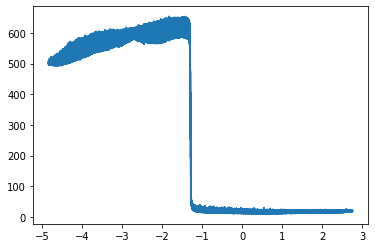

In [159]:
# Sort the pixel values based on distance
s_arr = np.array(s_arr)
val_arr = np.array(val_arr)
indx = s_arr.argsort()
s_arr = s_arr[indx]
val_arr = val_arr[indx]

# # Clip edge values
# s_arr = s_arr[5000:1200000]
# val_arr = val_arr[5000:1200000]

plt.plot(s_arr, val_arr)
plt.show()

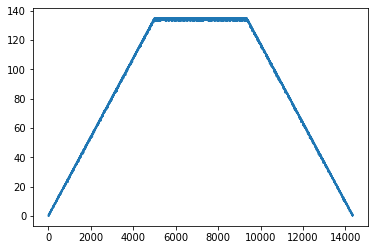

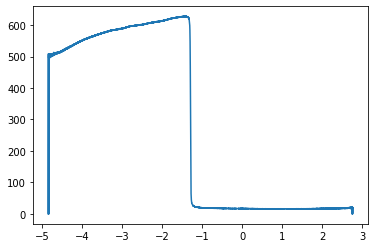

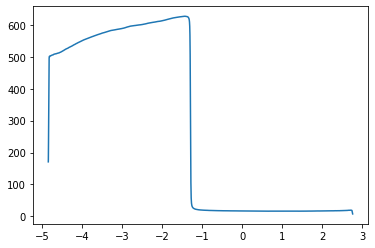

In [160]:
# Bin according to distance
bin_size = 0.1*p

min_val = np.amin(s_arr)
max_val = np.amax(s_arr)
bins = np.arange(min_val, max_val+bin_size, step=bin_size)
esf_indx = np.digitize(s_arr, bins)

esf_hist = np.zeros_like(bins)
for i in range(0, len(val_arr)):
    bin_idx = esf_indx[i]
    esf_hist[bin_idx] = esf_hist[bin_idx] + val_arr[i]

s_count = np.bincount(esf_indx)
# plt.plot(s_count)
# plt.show()

esf_hist = np.divide(esf_hist, s_count + 1e-20)
# esf_hist = np.histogram(s_arr, bins)

plt.plot(bins, esf_hist)
plt.show()

# Smoothing the esf with a gaussian kernel
esf_hist = gaussian_filter1d(esf_hist, 8)
plt.plot(bins, esf_hist)
plt.show()

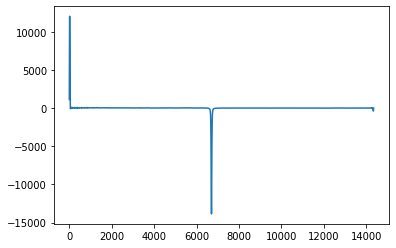

In [174]:
# Compute the LSF
lsf = np.ediff1d(esf_hist) /(2*bin_size)
# lsf = lsf[4000:8000]
# clip_range = range(6000,8000)
# plt.plot(clip_range,lsf[clip_range])
plt.plot(lsf)
plt.show()

# plt.plot(edge_t[327, :])
# plt.show()
# print(indx)

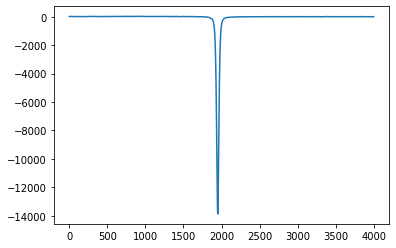

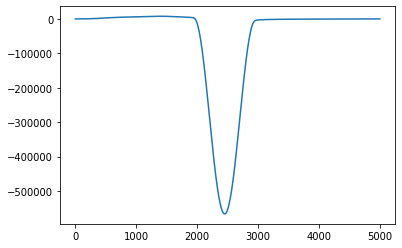

C:\Users\mayan\Anaconda3\envs\semiSupervised\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


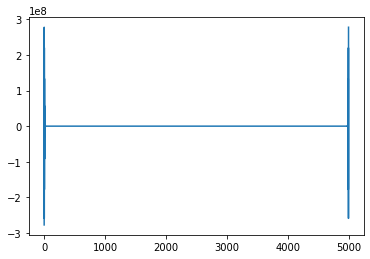

In [175]:
peak = 6750
lsf = lsf[peak-2000:peak+2000]
#smoothen using hanning window
hann_filter = np.hanning(1000)
lsf_smooth = np.convolve(lsf, hann_filter)

plt.plot(lsf)
plt.show()
plt.plot(lsf_smooth)
plt.show()

mtf = np.fft.fft(lsf_smooth)

plt.plot(mtf)
plt.show()

In [176]:
2000*bin_size
1024*p

5.4272